In [31]:
import pandas as pd
import numpy as np
import warnings as w
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, make_scorer

from imblearn.over_sampling import SMOTE  # Для оверсамплінгу
w.simplefilter('ignore')

In [32]:
df = pd.read_csv('pets_data.csv')

In [33]:
df.loc[df['AdoptionSpeed'] == 1, 'AdoptionSpeed'] = 0
df.loc[df['AdoptionSpeed'] == 2, 'AdoptionSpeed'] = 1
df.loc[df['AdoptionSpeed'] == 3, 'AdoptionSpeed'] = 1
df.loc[df['AdoptionSpeed'] == 4, 'AdoptionSpeed'] = 2

In [34]:
df.groupby('AdoptionSpeed').count()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
AdoptionSpeed,,,,,,,,,,,,,,,,,,,,,
0,321,321,321,321,321,321,321,321,321,321,...,321,321,321,321,321,321,321,321,321,321
1,615,615,615,615,615,615,615,615,615,615,...,615,615,615,615,615,615,615,615,615,615
2,353,353,353,353,353,353,353,353,353,353,...,353,353,353,353,353,353,353,353,353,353


In [35]:
y = df.iloc[:, -1]
X = df.drop('AdoptionSpeed', axis=1)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

In [37]:
# Ініціалізація SMOTE з потрібною стратегією вибірки
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [38]:
def statistics(y_test, y_pred, y_prob, n_classes):
    # Додаткова статистика
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Виведення текстових значень метрик
    print("\nКласифікаційний звіт:\n", classification_report(y_test, y_pred), '\n')
    
    # Візуалізація метрик у вигляді стовпчастого графіка
    metrics = ['precision', 'recall', 'f1-score']
    classes = list(report.keys())[:-3]  # Отримаємо всі класи (окрім 'accuracy', 'macro avg', 'weighted avg')
    
    # Створюємо окремі графіки для кожної метрики
    fig, ax = plt.subplots(1, len(metrics), figsize=(18, 6))
    for i, metric in enumerate(metrics):
        values = [report[class_name][metric] for class_name in classes]
        ax[i].bar(classes, values, color='b', alpha=0.7)
        ax[i].set_title(metric.capitalize())
        ax[i].set_xlabel('Класи')
        ax[i].set_ylabel('Значення')
        ax[i].set_ylim(0, 1)  # Значення метрик від 0 до 1
        ax[i].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Візуалізуємо матрицю плутанини
    conf_matrix = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap='Blues')
    plt.show()

    # Підготовка для побудови ROC-кривих
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))  # Бінаризація для багатокласової задачі
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Обчислюємо значення для кожного класу
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Побудова багатокласової ROC-кривої
    plt.figure(figsize=(10, 8))
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green']  # Можна додати більше кольорів для багатокласових задач
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC клас {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-крива для багатокласової класифікації')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


## Logistic Regression ##

In [39]:
log_reg = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000)
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'solver': ['lbfgs', 'newton-cg', 'saga'],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')
grid_search.fit(X_res, y_res)

# 6. Виводимо найкращі гіперпараметри
best_log_reg = grid_search.best_estimator_
print("Найкращі гіперпараметри:", grid_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Найкращі гіперпараметри: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}


In [40]:
#Оцінка важливості ознак (через коефіцієнти Logistic Regression)
importances = np.abs(best_log_reg.coef_).mean(axis=0)
feature_importances = pd.DataFrame(importances, index=[f"Feature {i}" for i in range(X_res.shape[1])], columns=['Importance'])
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Виведення важливостей ознак
print("Важливості ознак:")
print(feature_importances)

Важливості ознак:
            Importance
Feature 13    0.286389
Feature 14    0.219780
Feature 1     0.191688
Feature 12    0.147457
Feature 9     0.081709
Feature 4     0.076028
Feature 34    0.072740
Feature 2     0.065916
Feature 25    0.059382
Feature 37    0.058696
Feature 5     0.052225
Feature 17    0.040766
Feature 21    0.037964
Feature 24    0.037442
Feature 31    0.035358
Feature 6     0.031879
Feature 18    0.030305
Feature 36    0.029853
Feature 8     0.028843
Feature 30    0.028101
Feature 10    0.027722
Feature 16    0.025235
Feature 26    0.020747
Feature 19    0.018631
Feature 27    0.014920
Feature 35    0.012927
Feature 32    0.006740
Feature 0     0.005366
Feature 7     0.005167
Feature 23    0.003537
Feature 11    0.003028
Feature 3     0.001619
Feature 33    0.001586
Feature 22    0.000246
Feature 20    0.000000
Feature 28    0.000000
Feature 29    0.000000
Feature 15    0.000000


In [41]:
from sklearn.feature_selection import SelectFromModel

# SelectFromModel для вибору ознак
selector = SelectFromModel(best_log_reg, threshold=0.01, prefit=True)
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

Остаточний класифікаційний звіт:

Класифікаційний звіт:
               precision    recall  f1-score   support

           0       0.41      0.61      0.49        92
           1       0.53      0.27      0.36       193
           2       0.35      0.52      0.42       102

    accuracy                           0.42       387
   macro avg       0.43      0.47      0.42       387
weighted avg       0.45      0.42      0.40       387
 



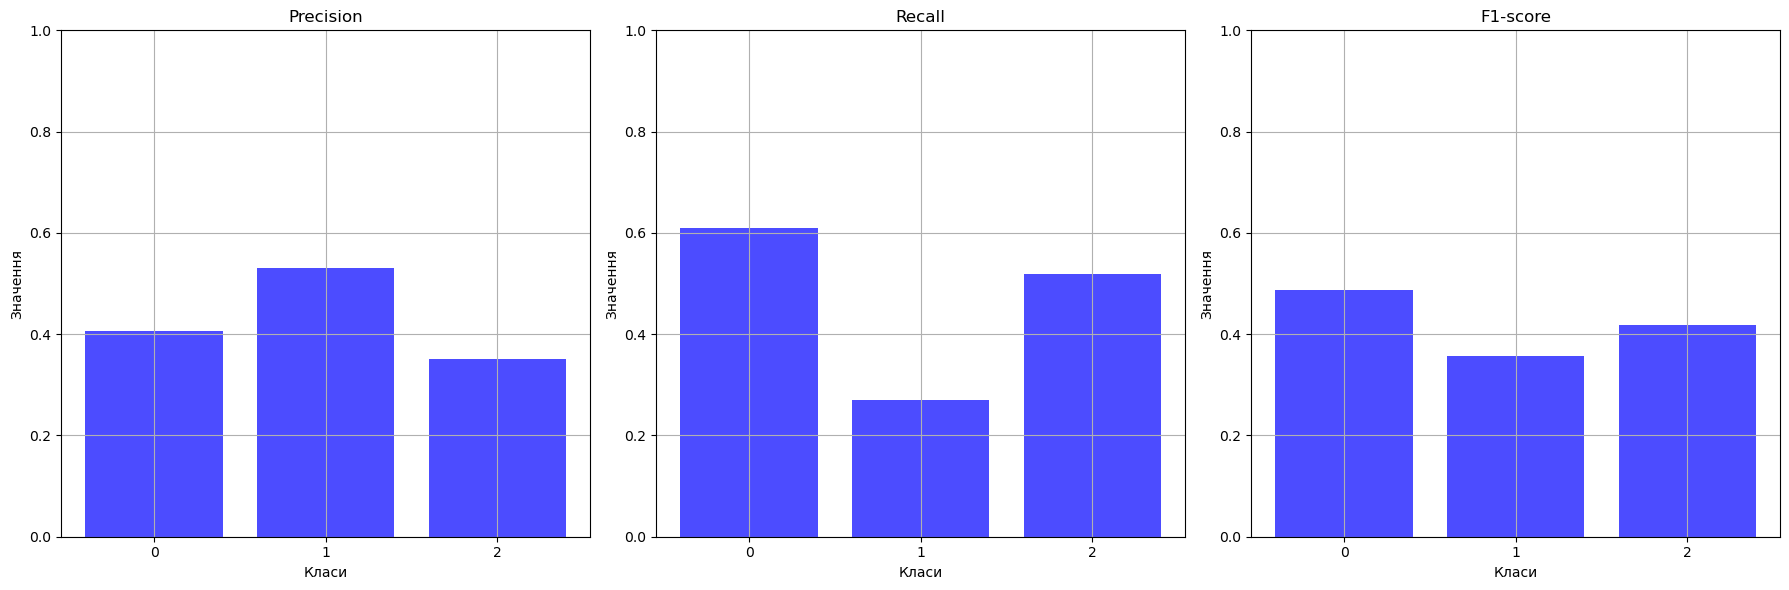

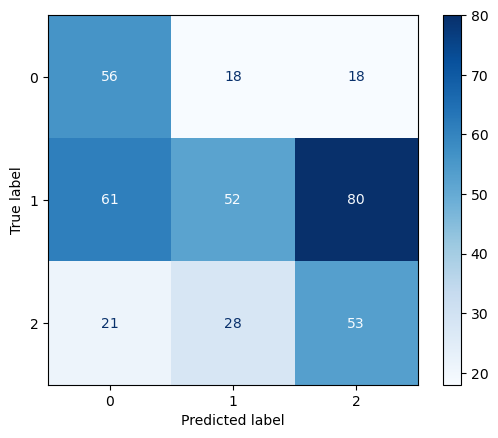

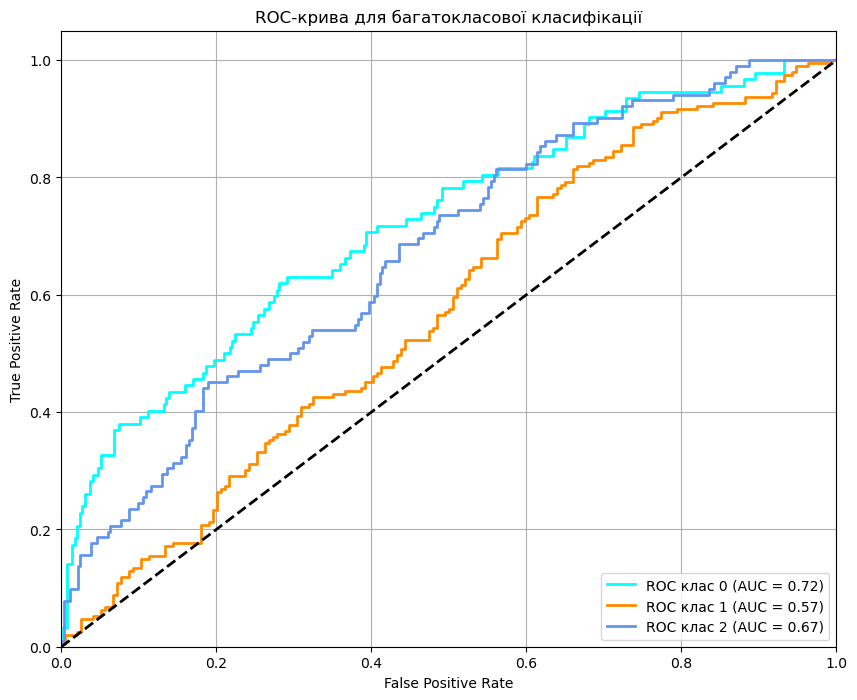

None


In [42]:
best_log_reg.fit(X_train_sel, y_train)

# Передбачення на основі вибраних ознак
y_pred_final = best_log_reg.predict(X_test_sel)
y_prob = best_log_reg.predict_proba(X_test_sel)

# Виведення остаточного класифікаційного звіту
print("Остаточний класифікаційний звіт:")
print(statistics(y_test, y_pred_final, y_prob, 3))

## Random Forest ##

In [43]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample'],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_res, y_res)
best_rf = grid_search.best_estimator_

print(grid_search.best_params_)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [46]:
from sklearn.feature_selection import SelectFromModel

# SelectFromModel для вибору ознак
selector = SelectFromModel(best_rf, threshold=0.01, prefit=True)
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

Остаточний класифікаційний звіт:

Класифікаційний звіт:
               precision    recall  f1-score   support

           0       0.44      0.43      0.44        92
           1       0.56      0.52      0.54       193
           2       0.43      0.49      0.46       102

    accuracy                           0.49       387
   macro avg       0.48      0.48      0.48       387
weighted avg       0.50      0.49      0.49       387
 



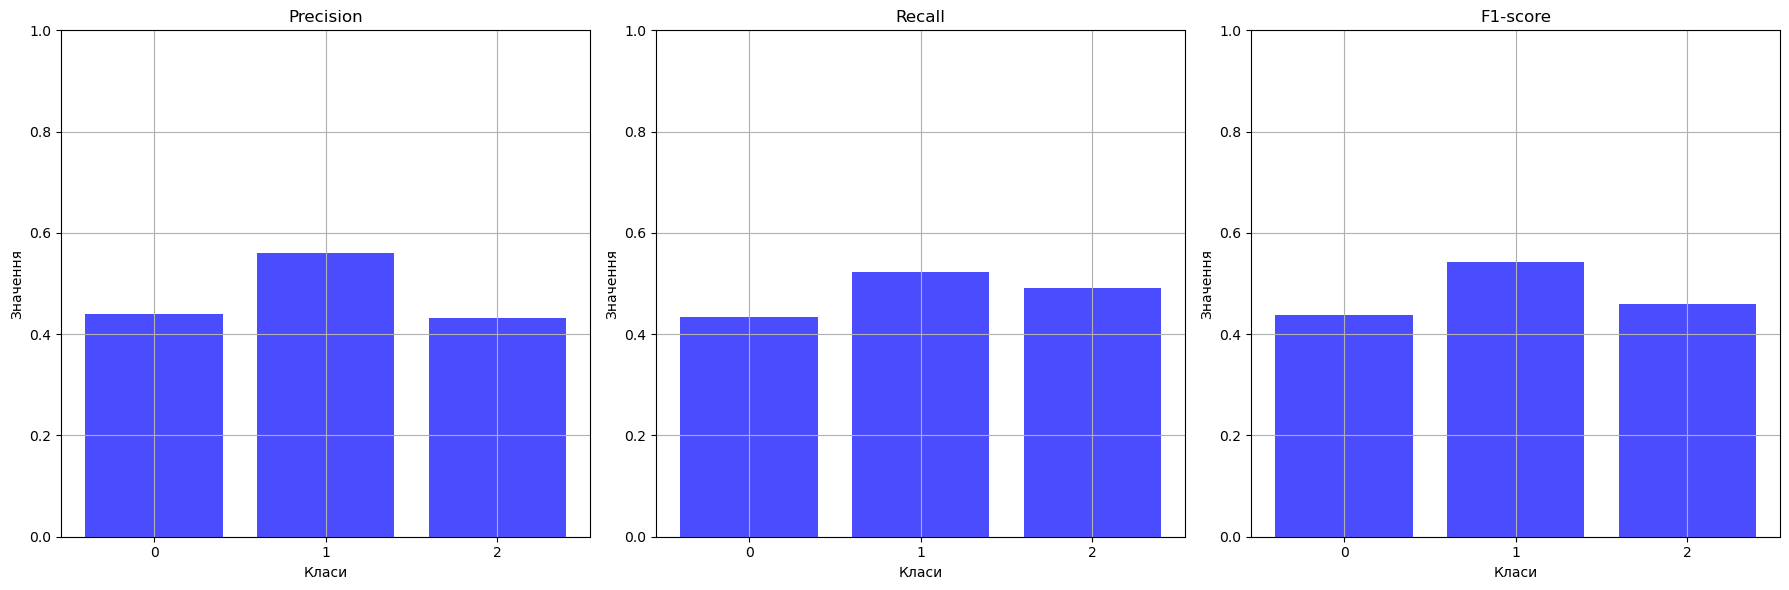

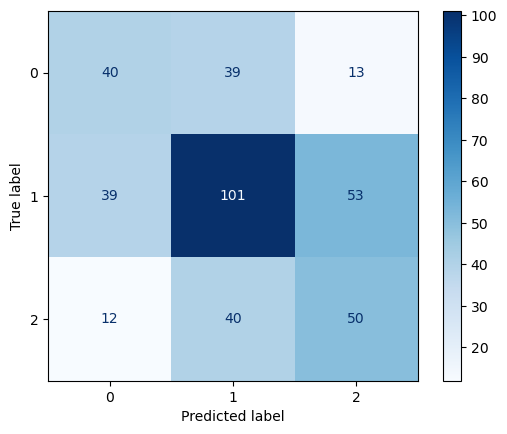

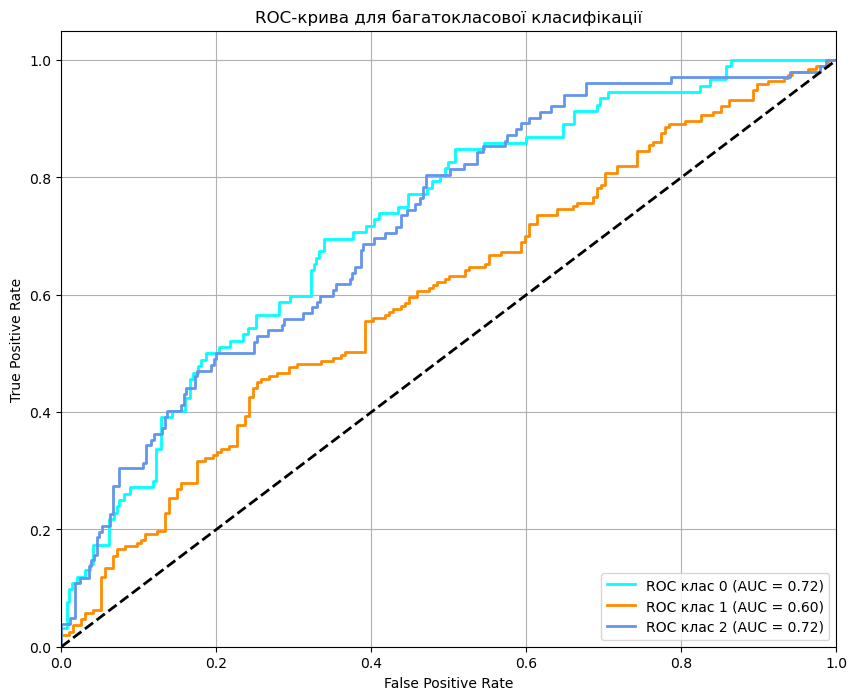

None


In [47]:
best_rf.fit(X_train_sel, y_train)

# Передбачення на основі вибраних ознак
y_pred_final = best_rf.predict(X_test_sel)
y_prob = best_rf.predict_proba(X_test_sel)

# Виведення остаточного класифікаційного звіту
print("Остаточний класифікаційний звіт:")
print(statistics(y_test, y_pred_final, y_prob, 3))

## AdaBoost ##

In [55]:
# Ініціалізація моделі AdaBoost
ada_model = AdaBoostClassifier(random_state=42)

# Параметри для пошуку
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.5, 1.0],
    'algorithm': ['SAMME.R']
}

# GridSearchCV для налаштування параметрів
grid_search = GridSearchCV(estimator=ada_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_res, y_res)
best_ada = grid_search.best_estimator_

print("Найкращі параметри AdaBoost:", grid_search.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Найкращі параметри AdaBoost: {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 50}


In [56]:
# SelectFromModel для вибору ознак
selector = SelectFromModel(best_ada, threshold=0.01, prefit=True)
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)


Класифікаційний звіт:
               precision    recall  f1-score   support

           0       0.39      0.47      0.42        92
           1       0.58      0.42      0.49       193
           2       0.42      0.56      0.48       102

    accuracy                           0.47       387
   macro avg       0.46      0.48      0.47       387
weighted avg       0.49      0.47      0.47       387
 



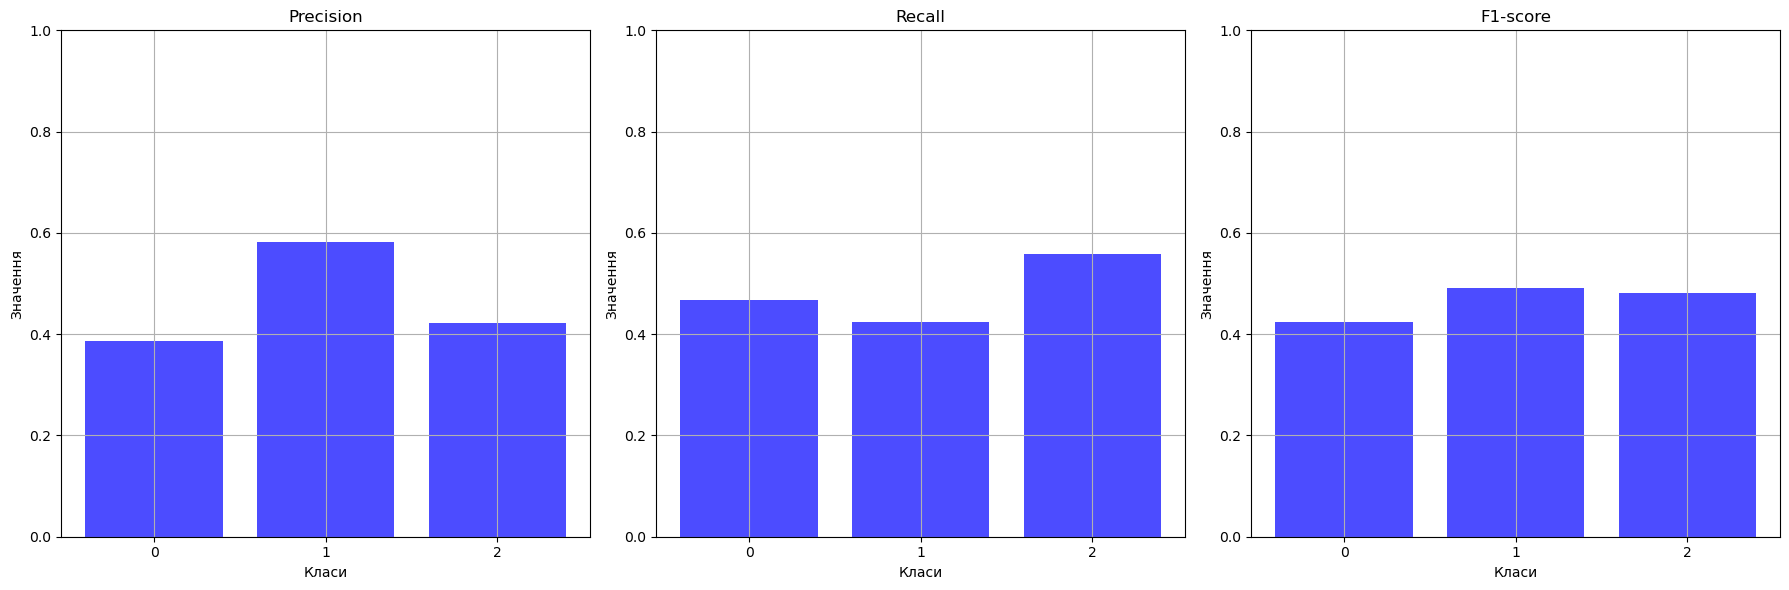

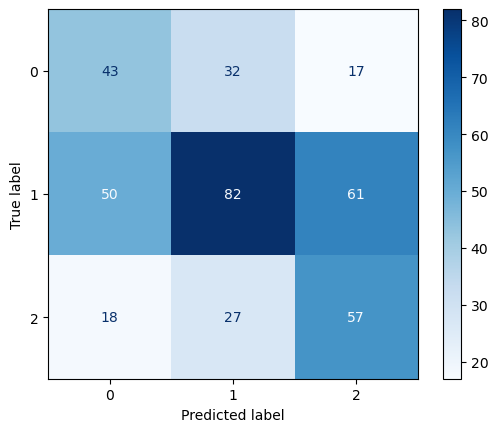

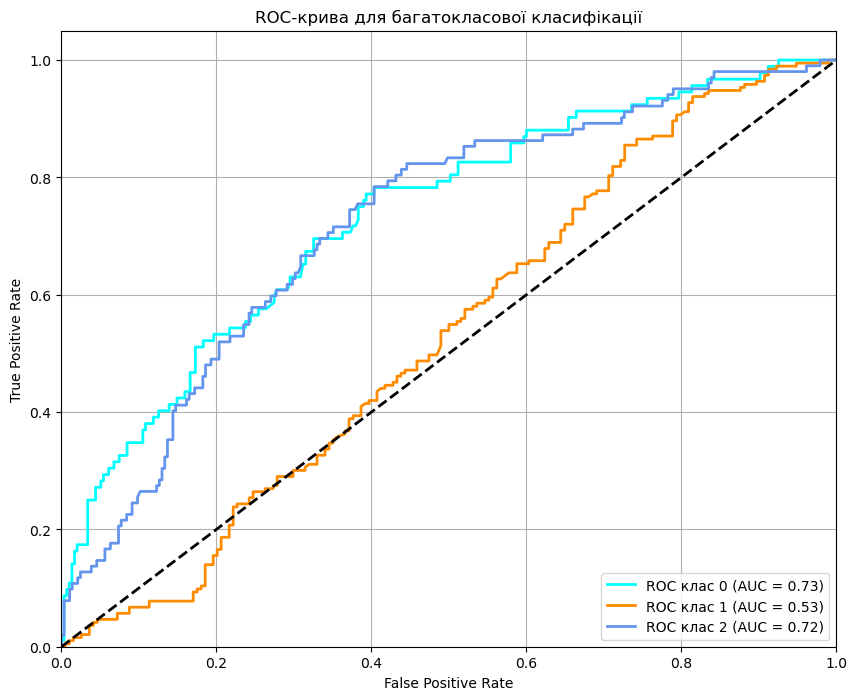

None


In [57]:
best_ada.fit(X_train_sel, y_train)
y_pred = best_ada.predict(X_test_sel)
y_prob = best_ada.predict_proba(X_test_sel)
print(statistics(y_test, y_pred, y_prob, 3))